![PyTorch Logo](images/pytorch1.png)

In [30]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

We will use not only basic functionlaity of `pytorch` but also **`torchvision`** computer vision library.

In [31]:
!pip freeze 2>/dev/null | grep torch

torch==1.2.0
torchvision==0.4.0a0+6b959ee


# Pytorch as a constructor

## Working with datasets

For data loading pytorch defines **`Dataset`** entity.

This abstract class is defined in `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
One should inherit `Dataset` and implement `__getitem__` and `__len__` nethods to create a new data source.

An example of such ancestor — `torchvision.datasets.ImageFolder`, which allows us to use imagenet-like dataset based on a directory with `./train/{class}` and `./val/{class}` sub-directories structure:

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Custom example — a dataset loading images with classes defined in some text file:

In [32]:
from torch.utils.data import Dataset
# default_loader - default image loading function, uses accimage or PIL
from torchvision.datasets.folder import default_loader

class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f'=> Found {len(self.imgs)} entries in {path}')

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [33]:
!echo '/tmp/1.jpg\tcat' > /tmp/dataset.tsv
!echo '/tmp/2.jpg\tcat' >> /tmp/dataset.tsv
!echo '/tmp/3.jpg\tdog' >> /tmp/dataset.tsv
!echo '/tmp/4.jpg\tcat' >> /tmp/dataset.tsv

In [34]:
catdog = TxtList('/tmp/dataset.tsv')

=> Found 4 entries in /tmp/dataset.tsv


In [35]:
catdog.classes

['cat', 'dog']

In [36]:
catdog.imgs

[['/tmp/1.jpg', 'cat'],
 ['/tmp/2.jpg', 'cat'],
 ['/tmp/3.jpg', 'dog'],
 ['/tmp/4.jpg', 'cat']]

In [37]:
len(catdog)

4

In [38]:
# FileNotFoundError
#catdog[0]

`torchvision` has another useful classes for using standard datasets: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Some of them can be preloaded with built-in functionality, for example **MNIST**:

In [39]:
![ -d '/tmp/mnist/' ] && rm -r '/tmp/mnist/'

In [40]:
from torchvision.datasets import MNIST

%time mnist = MNIST('/tmp/mnist/', train=True, download=True)

0it [00:00, ?it/s]

9920512it [00:01, 5707274.41it/s]                             


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 60605.09it/s]                            
0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw


1654784it [00:01, 1395464.08it/s]                            
0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


8192it [00:00, 31717.83it/s]            

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw
Processing...
Done!
CPU times: user 1.2 s, sys: 332 ms, total: 1.54 s
Wall time: 4.29 s


In [41]:
len(mnist)

60000

In [42]:
image, target = mnist[0]
print(target)

5


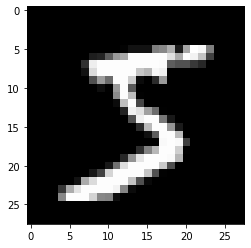

In [43]:
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Hometask!</font>

Implement **`UrlList`** dataset which costructor takes list of urls as a parameter.

In [44]:
from typing import List
import requests
import io
import base64
from PIL import Image

class UrlList(Dataset):
    def __init__(self, urls: List[str]):
        self.urls = urls
        
        self.images = []
        for url in self.urls:
            blob = io.BytesIO(requests.get(url).content)
            img = Image.open(blob).convert('RGB')
            self.images.append(img)

    def __getitem__(self, index):
        return self.images[index]
    
    def __len__(self):
        return len(self.urls)

Demonstrate how it works with some examples:

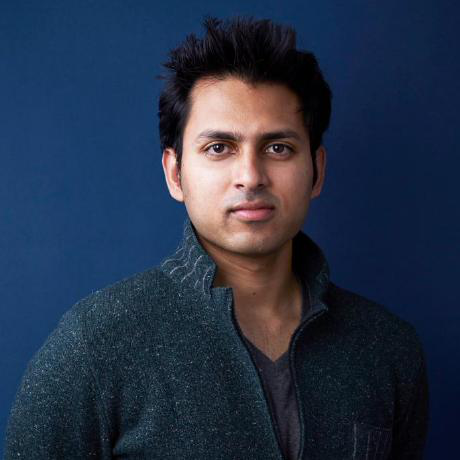

In [45]:
urls = [
    "https://avatars1.githubusercontent.com/u/1310570?s=460&v=4",
    "https://vignette.wikia.nocookie.net/prison-school/images/0/07/Hana_anime.jpg"
]

d = UrlList(urls)
d[0]

## Data transformation

In the example shown before and in built-in `ImageFolder` `__init__` methods has `transform` parameter (and `target_transform`).

They are used to transform images/targets loaded into predefined range and form.

There is `transforms` sub-module in `torchvision` library which has some examples of such transforms:

In [46]:
from torchvision import transforms

For example `transforms.ToTensor()` transforms uint8 `PIL` [0, 256)-domained images into [0, 1)-domained tensors.

In [47]:
to_tensor = transforms.ToTensor()

In [48]:
pil_image = mnist[0][0]
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

(torch.Size([1, 28, 28]), tensor(0.), tensor(1.))

One can define `normalize` to implement a standard ImageNet preparation step:

In [49]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

`transforms.Compose` is used to sequence several compositions as a whole:

In [50]:
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

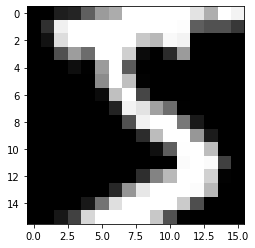

In [51]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), 'gray')
plt.show()

To define a custom transformer we should only implement `__call__` method its implementation:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

It is adviced to take a glance at http://pytorch.org/docs/master/torchvision/transforms.html for standard transformations overview.

## Optional reading

Another example of a good set of pre-defined transformations is [`albumentations`](https://github.com/albu/albumentations) library.

It supports not only image transformations but it can simultaniously transform its corresponding masks and bboxes.

One can also use [`imgaug`](https://github.com/aleju/imgaug) augmentations library but needs to implement `imguag output` -> `tensor` transformations on their own.

## <font color='#cc6666'>Hometask!</font>

Implement a transformer that applies random transformation from $D_4$ transformations group.

These transformations are very usefull for lossless augmentations in satellite images analysis.

In [52]:
import PIL.Image as Image

In [53]:
class RandomD4(object):
    def __call__(self, img):
        if np.random.randint(0, 2):
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        for _ in range(np.random.randint(0, 4)):
            img = img.rotate(90)
        return img

Demonstrate how it works on some MNIST images:

In [54]:
t = RandomD4()

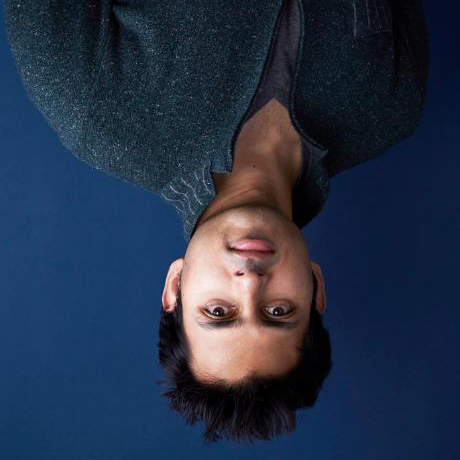

In [61]:
t(d[0])

## Data loaders

The main reason to implement `Dataset` class is a magic power of `torchvision` loaders:

In [88]:
from torch.utils.data import DataLoader

The loaders are built on top of some dataset and allow batch iterating over it.

Those batches in their turn are created with applying the transformations defined in background processes.

Let's look at MNIST dataset with a simple transformer applied as loaders use tensors and not `PIL.Image`s.

In [89]:
transformed_mnist = MNIST('/tmp/mnist/', train=True, transform=transforms.ToTensor())

In [90]:
mnist_loader = DataLoader(transformed_mnist, batch_size=16, shuffle=True, num_workers=4)  # shuffle note here

DataLoader standard parameter values are shown above.

One can also add **`pin_memory=True`** to page-lock the memory thus making faster cpu-to-cuda transfer with a non-blocking option.

**`drop_last=True`** is for avoiding batches size skew in the training process.

Let us demonstrate how it works:

In [91]:
for images, targets in tqdm(mnist_loader):
    pass




  0%|          | 0/3750 [00:00<?, ?it/s]


  0%|          | 1/3750 [00:00<15:43,  3.97it/s]


  2%|▏         | 75/3750 [00:00<10:49,  5.66it/s]


  5%|▍         | 175/3750 [00:00<07:23,  8.07it/s]


  8%|▊         | 287/3750 [00:00<05:01, 11.49it/s]


 10%|█         | 382/3750 [00:00<03:26, 16.33it/s]


 13%|█▎        | 480/3750 [00:00<02:21, 23.16it/s]


 16%|█▌        | 587/3750 [00:00<01:36, 32.78it/s]


 18%|█▊        | 687/3750 [00:00<01:06, 46.18it/s]


 21%|██        | 780/3750 [00:01<00:46, 64.27it/s]


 23%|██▎       | 867/3750 [00:01<00:32, 88.85it/s]


 25%|██▌       | 953/3750 [00:01<00:23, 121.38it/s]


 28%|██▊       | 1050/3750 [00:01<00:16, 164.58it/s]


 30%|███       | 1139/3750 [00:01<00:12, 217.48it/s]


 33%|███▎      | 1230/3750 [00:01<00:08, 281.78it/s]


 35%|███▌      | 1320/3750 [00:01<00:06, 353.96it/s]


 38%|███▊      | 1413/3750 [00:01<00:05, 433.88it/s]


 40%|████      | 1511/3750 [00:01<00:04, 519.91it/s]


 43%|████▎     | 1603/3750 [00:01<00:03, 59

There are image batches as tensors on the output:

In [92]:
images.shape

torch.Size([16, 1, 28, 28])

In [93]:
targets.shape

torch.Size([16])

The loader instance pre-calculate the total number of batches (what makes `tqdm` happy):

In [94]:
len(mnist_loader)

3750

Some data example (will be random on each run):

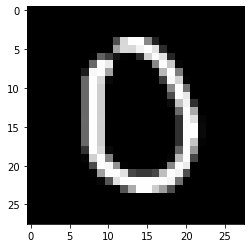

In [95]:
plt.imshow(images[0][0].numpy(), 'gray')
plt.show()

In [96]:
print(targets[0])

tensor(0)


## Building NN models

We should inherit `torch.nn.Module` class to implement pytorch model, `torch.nn` has lots of pre-defined "building bricks".

Their functional analogs are collected in `torch.nn.functional`.

In [97]:
import torch.nn as nn
import torch.nn.functional as F

We have both module and functional versions of max-pooling, activations, upsempling and some other ops:
* `nn.MaxPool2d` / `F.max_pool2d`
* `nn.ReLU` / `F.relu`
* `nn.Upsample(mode='bilinar')` / `F.upsample(mode='bilinar')` — **deprecated**, use `F.interpolate` instead

To compose several nn modules we can use `nn.Squential`:

In [98]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
)


## Models training

To train a model one must define a looss functions, some of them can also be found in `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = torch.arange(1, 1001)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

We can update the weights manually:

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Or use built-in optimizer from `torch.optim` family:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

We need to zero the gradients to disable gradient accumulations that happens by defult (`pytorch` sends its regards to `tf` rnn implementations):
```python
optimizer.zero_grad()
```

After zeroing the gradients we can run both forward and backward stage with loss calculation in-between:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

To update the weights we can use the optimizer again:
```python
optimizer.step()
```

To adjust learning rate in some pre-defined way we can use **`torch.optim.lr_scheduler`** sub-module:
```python
from torch.optim import lr_scheduler
```

To train ResNets on ImageNet with a standard training scheme we can use
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
    # no scheduler.step() here* 
    # train(...)
    # validate(...)
    scheduler.step()  # == scheduler.step(epoch)
```
\* one **should not** put `scheduler.step()` before `optimizer.step()`, otherwise the first epoch will be "skipped".

## Optional reading

There are several libraries out there like [`catalyst`](https://github.com/catalyst-team/catalyst) or [`kekas`](https://github.com/belskikh/kekas) that make building pipelines even easier.

# Pytorch in the wils

## Segmentation model creation (with U-Net as an example)

![U-Net scheme](images/unet.png)

In [99]:
import torch
from torch import nn

Pre-defined heavily-used convolutions:

In [100]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

One **encoder block** consists of two sequential convolutions, an activation layer and an optional batch-norm:

In [101]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [102]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [103]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Alternative definition:

In [104]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [105]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (block): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
)

In [106]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


And its "functional" version:

In [107]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [108]:
block = encoder_block(3, 64)
block

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [109]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Encoder is composed from several encoder blocks.

Its final form is defined bu the number of input channels, the number of channels in the first block output and the number of such blocks.

And we need to store preliminary activatons to apply Decoder on.

In [110]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

Here we can use **`add_module`** way of layers definition as its number is variable.

In [111]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(32, 64, kernel_s

In [112]:
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

Decoder block consists of upscaling "lower" output and concatenating it with a saved encoder block output from the "left".

In [113]:
Upsample = nn.Upsample

# class Upsample(nn.Module):
#     def __init__(self, scale_factor=2, mode='bilinear'):
#         super().__init__()

#         self.scale_factor = scale_factor
#         self.mode = mode

#     def forward(self, x):
#         return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=True)

class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [114]:
block = DecoderBlock(8)

In [115]:
y = encoder(x)

In [116]:
y[1].shape, y[0].shape

(torch.Size([4, 16, 256, 256]), torch.Size([4, 8, 512, 512]))

In [117]:
block(y[1], y[0]).shape

/home/b.lestsov/anaconda3/envs/ssl_det/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))

1654784it [00:57, 17644.48it/s]                             

torch.Size([4, 8, 512, 512])

Let us build Decoder from several decoder blocks:

In [118]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [119]:
decoder = Decoder(8, 3)

In [120]:
x.shape

torch.Size([4, 3, 512, 512])

In [121]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

In [122]:
decoder(encoder(x)).shape

torch.Size([4, 8, 512, 512])

U-Net is build from Encoder, Decoder and a final classification layer:

In [123]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f'=> Building {num_blocks}-blocks {num_filters}-filter U-Net')

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Integration testing" (pytorch 0.3 legacy code):

In [124]:
from torch.autograd import Variable

model = UNet(num_classes=1)
if torch.cuda.is_available():
    model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
if torch.cuda.is_available():
    images = images.cuda()

model.forward(images).shape

=> Building 4-blocks 64-filter U-Net


/home/b.lestsov/anaconda3/envs/ssl_det/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


torch.Size([4, 1, 416, 416])

```
/home/nizhib/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
```

Same for **pytorch 0.4+**:

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(num_classes=1)
model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)

with torch.no_grad():
    print(model.forward(images).shape)

=> Building 4-blocks 64-filter U-Net
torch.Size([4, 1, 416, 416])


We get linear activations as an output.

To train such models we need to use **/.\*WithLogits/** loss functions subset

We can use `torch.sigmoid` or `torch.softmax` to get probabilities (**0.4.1+**, `torch.nn.functional.sigmoid/softmax` before)

## Using pretrained encoder

Encoder blocks structure seen before looks exactly like VGG architecture:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Let us have a look at VGG model from `torchvision` library:

In [126]:
from torchvision.models import vgg13

VGG13 is the VGG version with 2 convolutional layer in each block:

In [127]:
model = vgg13()

In [128]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

We don't need the classifier, only the features are useful.

They are built from conv-relu-conv-relu + maxpooling.

Let's build encoder blocks via grouping VGG layers:

In [129]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f'block{i + 1}', block)
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

In [130]:
vgg_encoder = VGG13Encoder(num_blocks=4, pretrained=False)
vgg_encoder

VGG13Encoder(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequenti

Compare it to "vanilla" encoder:

In [131]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(256, 

Both structures are identical!

But now we have some usefull pretrained weights in the decoder.

## <font color='#cc6666'>Hometask!</font>

### Part1. Toy dataset


**Implement** toy dataset to generate noisy ellipses like that:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

The dataset should output both the image and its corresponding mask.

In [73]:
def create_image_and_label(h, w, c, n=10, min_r=5, max_r=50, sigma=20):
    
    image = np.ones((h, w, c))
    image[..., :] = np.random.randint(1, 255, size=(c,))
    mask = np.zeros((h, w), dtype=np.bool)
    
    for i in range(n):
        x = np.random.randint(max_r, h - max_r)
        y = np.random.randint(max_r, w - max_r)
        r = np.random.randint(min_r, max_r)
        col = np.random.randint(1, 255, size=(c,))

        x_grid, y_grid = np.ogrid[-y:h-y, -x:w-x]
        m = (x_grid**2 + y_grid**2 <= r**2)
        mask |= m

        image[m] = col

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    return image, mask


In [66]:
class Ellipses(Dataset):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(Dataset, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def __getitem__(self, index):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return data, label

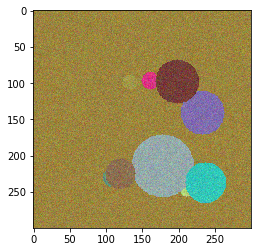

In [81]:
e = Ellipses(300, 300, c=3)
plt.imshow(e[0][0])

Define utility function:

In [135]:
import hashlib

def moy_variant(surname):
    return int(hashlib.md5(surname.encode().lower()).hexdigest()[-1], 16) % 2

In [86]:
moy_variant("Lestsov")

1

**Implement ACFNet** (https://arxiv.org/abs/1909.09408, if `moy_variant` returns 1 for you) **or OCRNet** (https://arxiv.org/abs/1909.11065, otherwise) based on pretrained **DenseNet** (pytorch) and **DPN** (cadene/pretrainedmodels) networks instead of ResNets from the papers.

It is advised to use `BCEWithLogitsLoss` as a loss function.

In [8]:
from seg.models_seg import ACFDenseNet, ACFDPN

In [209]:
model = ACFDPN(2)

In [206]:
img, label = create_image_and_label(224, 224, c=3)
img = torch.from_numpy(img.transpose(2,0,1).astype(np.float32)).unsqueeze(0)#.cuda()
label = torch.from_numpy(label)#.cuda()

model(img.cpu())

torch.Size([1, 3, 224, 224])
torch.Size([1, 2688, 28, 28])


/home/b.lestsov/anaconda3/envs/ssl_det/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(tensor([[[[1.4275, 0.7561, 0.7561,  ..., 0.5557, 0.5557, 0.0000],
           [0.8804, 0.9134, 0.9134,  ..., 1.5500, 1.5500, 0.5555],
           [0.8804, 0.9134, 0.9134,  ..., 1.5500, 1.5500, 0.5555],
           ...,
           [0.0000, 0.4092, 0.4092,  ..., 1.5068, 1.5068, 0.5126],
           [0.0000, 0.4092, 0.4092,  ..., 1.5068, 1.5068, 0.5126],
           [0.6980, 0.8984, 0.8984,  ..., 1.0168, 1.0168, 0.4394]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [1.9501, 0.9470, 0.9470,  ..., 0.0000, 0.0000, 0.0000],
           [1.9501, 0.9470, 0.9470,  ..., 0.0000, 0.0000, 0.0000],
           [1.3701, 1.2639, 1.2639,  ..., 0.0000, 0.0000, 0.0000]]]],
        grad_fn=<ReluBackward0>),
 tensor([[[[3.1674, 0.7287, 0.7287,  ..., 0.0000, 0.0000, 0.0000],
           [0.6544, 0.0000, 0.0000,  ..., 0.0000, 0.0000,

![title](./seg/sc1.png)

![title](./seg/sc2.png)

**Demonstrate** how they are trained with `tensorboard` screenshots (use `tensorboardX` library).

That includes but not limited to loss curves, masks from different epochs etc.

### Part2. Portrait Segmentation

Repeat the training procedures on some real task: http://xiaoyongshen.me/webpage_portrait/.

Easy-to-use dataset version can be downloaded from https://yadi.sk/d/1SSkfLh4WnEhmw.

Use `dice score` as a target scoring function, it should be published in the final report.

All the loss charts, mask quality evolution and final mask examples are expected as well.

### Part 3. Bells and whistles

* Use at least 5 `albumentations` or `imgaug` augmentations on the data preparation step (up to 0.5 bonus points);


* Use `catalyst` or `kekas` to build the training pipeline (up to 0.5 bonus points);


* Deploy the web demo to play with on your own `dl2019fall-{lastname}.ml` domain.

  The demo earns 0.1 bonus points for each day it's alive in the range from **Oct 14 00:00 to Oct 27 23:59**.

  You can use https://github.com/nizhib/portrait-demo as a start point (up to 2 bonus points for 2-week streak).